In [1]:
import numpy

In [2]:
# Author: Elisabetta Ghisu

"""
- Script containing functions for computing the shortest path kernel
- The Floyd Warshall algorithm is first implemented
- Then the SP is calculated
"""


#######################
# - IMPORT PACKAGES - #
#######################



import numpy.matlib as matlib
import numpy as np

"""
### FLOYD WARSHALL ALGORITHM
Input:
- Adjancency matrix A
Output:
- Shortest path matrix S
"""

def floyd_warshall(A):

	# nuber of nodes
	n = A.shape[0]

	# initialize shortes path matrix
	S = np.zeros(shape = (n,n))

	for i in range(n):
		for j in range(n):
			if A[i,j] == 0 and i!=j:
				S[i,j] = float("inf")
			else:
				S[i,j] = A[i,j]

	# Compute the shortest path matrix
	for k in range(n):
		for i in range(n):
			for j in range(n):
				if S[i,j] > S[i,k] + S[k,j]:
					S[i,j] = S[i,k] + S[k,j]

	return S								



"""
SHORTEST PATH KERNEL: This is a fast implementation of the shortest path
kernel algorithm
Inputs
- Adjancency matrix
- List of list of node labels for each graph
- Total number of node labels 
Outputs
- Kernel matrix
- Feature matrix
"""

def sp_kernel_fast(adj_mat, labels, L):

	# Number of graphs
	n = len(adj_mat)
	L = int(L)
	S = []

	# shortest path matrices
	for i in xrange(n):
		if i%1000 == 0 and i !=0:
 			print('haha') #( "%d" % i)
		S.append(floyd_warshall(adj_mat[i]))
	
	# maximum length of shortest paths in the dataset
	max_path = 0

	# for each graph in dataset
	for i in xrange(n):

		S_cur = np.copy(S[i])
		S_cur[S_cur == np.inf] = 0
		new_max = np.max(S_cur)
		
		if new_max > max_path:
			max_path = new_max # get max short path in all Ss

	# maximum length of shortest paths
	max_path = int(max_path)

	# initialize feature matrix
	sp = np.zeros(((max_path + 1) * L * (L+1) /2,n))

	# compute feature map for shortest path
	for i in xrange(n):

		if i % 1000 == 0:
			print('haha') #"Processed %d graphs" %i

		S_graph = S[i]
		labels_graph = np.asarray(labels[i].reshape((len(labels[i]),1)))
		labels_graph = labels_graph + 1
		
		labels_aux = matlib.repmat(labels_graph, 1, len(labels_graph))
		
		min_lab = np.minimum(labels_aux, labels_aux.T)
		
		max_lab = np.maximum(labels_aux, labels_aux.T)
		sub_path = np.triu(~(np.isinf(S_graph))).T

		min_lab = min_lab[sub_path]
		max_lab = max_lab[sub_path]


		ind = S_graph[sub_path] * L * (L + 1) / 2 + (min_lab - 1) * (2*L + 2 - min_lab) / 2 + max_lab - min_lab
		ind = ind.astype(int)
		accum = np.zeros((max_path + 1) * L * (L + 1) /2)
		accum[:ind.max() + 1] += np.bincount(ind.astype(int))
		sp[ind,i] = accum[ind]
	
	sum_cols = np.sum(sp, axis = 1)
	ind_true = sum_cols != 0
	sp = sp[ind_true,:]
	
	# compute kernel matrix
	K = np.dot(sp.T,sp)
    
	return K, sp

In [3]:
#Authors: Elisabetta Ghisu, Felipe Llinares Lopez

"""
- This script includes a list of functions for analyzing 
parsing and formatting graphs
- The graphs are given in graphml format
- It also contains functions for loading, processing the graphs
and extract graph statistics
"""


import numpy as np
from numpy import genfromtxt

# iGraph imports to handle graphs and for graph I/O
from igraph import Graph


# ---------------------------------GRAPHML I/O FUNCTIONS------------------------------------ #

# INPUT:
# filenames_graphs: list of GraphML files, where each file contains one graph in the dataset
# filename_labels: text file with labels corresponding to each graph in the dataset, in the same order as they are in
#                  filename_graphs
# OUTPUT:
# G: A list containing one iGraph object for each graph in the dataset
# Y: A Numpy array containing the labels corresponding to each graph, in the same order as G
def load_graphml(filenames_graphs, filename_labels):
    G = []
    for fname in filenames_graphs:
        G.append(Graph.Read_GraphML(fname))
    Y = genfromtxt(filename_labels)
    return (G, Y)


# Loads a list of paths to GraphML files from filename_list
def load_file_list(filename_flist):
    f = open(filename_flist, 'r')
    f_graphs = []
    for line in f:
        f_graphs.append(line.strip())
    f.close()
    return f_graphs


# --------------------------------COMPUTE STATISTICS---------------------------------------- #


# Retrieve labels of all vertices belonging to any graph in the list of iGraph objects G and
# returns the entire list, and a list with the alphabet of the vertex labels
def get_all_vertex_labels(G, att_name='label'):
    v_l = []
    for g in G:
        v_l += g.vs[att_name]
    return (v_l, np.unique(v_l))


# Retrieve labels of all edges belonging to any graph in the list of iGraph objects G and
# returns the entire list, and a list with the alphabet of the edge labels
def get_all_edge_labels(G, att_name='label'):
    e_l = []
    for g in G:
        e_l += g.es[att_name]
    return (e_l, np.unique(e_l))


# Returns a list where each element is itself the adjacency list of the corresponding graph
# The adjacency lit of a graph has the following format:
# it is a list where each element is a list containing the id of adjacent nodes
def get_adj_list(G):
    ad_l = []
    for g in G:
        ad_l.append(g.get_adjlist())
    return ad_l

# Returns a list where each element is the adjacency matrix of the graph 
# The adjancency matrix is in iGraph format
def get_adj_mat(G):
    ad_m = []
    for g in G:
        ad_m.append(g.get_adjacency())
    return ad_m

# Returns a list where each element contains the nodes label for a graph
def get_node_labels(G, att_name = 'label'):
    node_l = []
    for g in G:
        node_l.append(g.vs[att_name])
    return node_l



# ----------------- LOAD AND PROCESS THE GRAPHS --------------- #


"""
Inputs:
- list of graphs file
- labels file
- path to the data folder
Outputs:
- List of node labels
- List of adjancency lists
- List of graphs in graphml format
- Targets
- number of classes
- sample size
"""


def load_and_process(filenames_graphs, filename_labels, path_to_dataset):

    # load a list of names to graphml files
    f_graphs = load_file_list(filenames_graphs)
    # sample size
    n = len(f_graphs)

    # create a list of paths to the files
    f_graphs_path =[]

    # for each graph in dataset
    for i in range(n):

        # index the graph
        graph_name = f_graphs[i]

        # path to the data folder
        path = "%s/%s" % (path_to_dataset, graph_name)
        f_graphs_path.append(path)

    # If the data is DD have to delete an element (corrupted file)
    if graph_name == "DD":
        del f_graphs_path[148]
        n = n-1

    # Load the graphs in graphml format
    # G is a llist of graphml graph
    # Y is an array of targets
    G,Y = load_graphml(f_graphs_path, filename_labels)

    # Delete corrupted file in DD
    if graph_name == "DD": 
        Y = np.delete(Y, 148)

    # get adjacency list and matrix for all the graphs in G
    ad_list = get_adj_list(G)
    ad_mat = get_adj_mat(G)

    # get a list containing lists of node labels
    node_label = get_node_labels(G)

    return node_label, ad_list, G, Y



"""
RENAME NODES: function to rename nodes from 0,...,num_nodes
Input
- list of list of node labels in each graph
Output
- L: total number of different labels in the dataset
- node_label: new renamed labels
"""

def rename_nodes(node_label): 
    
    # number of graphs in the dataset
    n = len(node_label)

    # labels will store the new labels
    labels = [0] * n

    # disctionary containing the map from the old to the new labels
    label_lookup = {}

    # counter of unique labels
    label_counter = 0

    # for each graph in dataset
    for i in range(n):


        # number of nodes in graph[i]
        num_nodes = len(node_label[i]) 

        # will be used to store the new labels
        labels[i] = np.zeros(num_nodes, dtype = np.uint64) # positive integers

        # for each node in the graph
        for j in range(num_nodes):

            # the node label to a string
            l_node_str = str(np.copy(node_label[i][j]))
            
            # if the string has not been observed yet
            # the corresponding node is assigned a new label
            # otherwise it will be named with the same label
            # already assigned to an identical string

            if not label_lookup.has_key(l_node_str):
                label_lookup[l_node_str] = label_counter
                labels[i][j] = label_counter                                                              
                label_counter += 1
            else:
                labels[i][j] = label_lookup[l_node_str]

    # total number of labels in the dataset
    L = label_counter
    print('haha') #'Number of original labels %d' % L 

    return L, labels

ModuleNotFoundError: No module named 'igraph'

In [4]:
# Author: Elisabetta Ghisu

"""
- Script for computing the kernel matrix and features map 
using shortest path kernel
"""

###########################
# --- IMPORT PACKAGES --- #
###########################

import numpy as np
import argparse
import os
import pickle

from numpy import genfromtxt

# from sp_functions import *
# from parse_graphs import *



##############################
### Command Line Arguments ###
##############################

parser = argparse.ArgumentParser(description = "Compute kernel and features matrices via shortest path kernel")
parser.add_argument("--dataset", required = True, help = "Name of the dataset")
args = parser.parse_args()


#####################
### LOAD THE DATA ###
#####################

"""
- Here we load the data input and targets
- The data are assumed to be in graph formats
- They should be in graphml format 
"""

# path to the list of graphs and dataset
filenames_graphs = "data/%s.list" % (args.dataset)
path_to_dataset = "data/%s" % (args.dataset) 

# Load the targets
filename_labels = "data/%s_label.txt" % (args.dataset)

# load and process graphs
node_label, ad_list, G, Y = load_and_process(filenames_graphs, filename_labels, path_to_dataset)

# output directory
out_path = "kernel_matrices/%s/sp" % args.dataset

# If the output directory does not exist, then create it
if not os.path.exists(out_path):
    os.makedirs(out_path)


#########################
# --- SHORTEST PATH --- #
#########################


# assign labels starting from zero to the nodes
L, labels = rename_nodes(node_label)


# Compute adjancency matrix 
adj_mat = get_adj_mat(G)

# Compute kernel and feature maps using shortest path
K, phi = sp_kernel_fast(adj_mat, labels, L)

# save kernel matrix
file_name = "%s/%s_ker_mat" % (out_path, args.dataset)
np.save(file_name, K)

# save feature map
file_name = "%s/%s_phi_map" % (out_path, args.dataset)
np.save(file_name, phi)

usage: ipykernel_launcher.py [-h] --dataset DATASET
ipykernel_launcher.py: error: the following arguments are required: --dataset


SystemExit: 2

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3273: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
import networkx as nx
   
def loadCT(filename):
    """load data from .ct file.
    
    Notes
    ------ 
    a typical example of data in .ct is like this:
    
     3 2  <- number of nodes and edges
        0.0000    0.0000    0.0000 C <- each line describes a node, the last parameter in which is the label of the node, representing a chemical element @Q what are the first 3 numbers?
        0.0000    0.0000    0.0000 C
        0.0000    0.0000    0.0000 O
      1  3  1  1 <- each line describes an edge, the first two numbers represent two nodes of the edge, the last number represents the label. @Q what are the 3th numbers?
      2  3  1  1
    """
    content = open(filename).read().splitlines()
    G = nx.Graph(name=str(content[0])) # set name of the graph
    tmp = content[1].split(" ")
    if tmp[0] == '':
        nb_nodes = int(tmp[1]) # number of the nodes
        nb_edges = int(tmp[2]) # number of the edges
    else:
        nb_nodes = int(tmp[0])
        nb_edges = int(tmp[1])

    for i in range(0, nb_nodes):
        tmp = content[i + 2].split(" ")
        tmp = [x for x in tmp if x != '']
        G.add_node(i, label=tmp[3])

    for i in range(0, nb_edges):
        tmp = content[i + G.number_of_nodes() + 2].split(" ")
        tmp = [x for x in tmp if x != '']
        G.add_edge(int(tmp[0]) - 1, int(tmp[1]) - 1, label=int(tmp[3]))
    return G


def loadGXL(filename):
    import networkx as nx
    import xml.etree.ElementTree as ET

    tree = ET.parse(filename)
    root = tree.getroot()
    index = 0
    G = nx.Graph()
    dic={}
    for node in root.iter('node'):
        label = node.find('attr')[0].text
        dic[node.attrib['id']] = index
        G.add_node(index, id=node.attrib['id'], label=label)
        index += 1
        
    for edge in root.iter('edge'):
        label = edge.find('attr')[0].text
        G.add_edge(dic[edge.attrib['from']], dic[edge.attrib['to']], label=label)
    return G
 
def loadDataset(filename):
    """load file list of the dataset.
    """
    from os.path import dirname, splitext

    dirname_dataset = dirname(filename)
    extension = splitext(filename)[1][1:]
    data = []
    y = []
    if(extension == "ds"):
        content = open(filename).read().splitlines()
        for i in range(0, len(content)):
            tmp = content[i].split(' ')
            data.append(loadCT(dirname_dataset + '/' + tmp[0].replace('#', '', 1))) # remove the '#'s in file names
            y.append(float(tmp[1]))
    elif(extension == "cxl"):
        import xml.etree.ElementTree as ET

        tree = ET.parse(filename)
        root = tree.getroot()
        data = []
        y = []
        for graph in root.iter('print'):
            mol_filename = graph.attrib['file']
            mol_class = graph.attrib['class']
            data.append(loadGXL(dirname_dataset + '/' + mol_filename))
            y.append(mol_class)

    return data, y

In [6]:
import sys
import pathlib
sys.path.insert(0, "../../")


import networkx as nx
import numpy as np
import time

from gklearn.utils.utils import getSPGraph


def spkernel(Gn):
    """Transform graph G to its corresponding shortest-paths graph using Floyd-transformation.
    
    Parameters
    ----------
    G : NetworkX graph
        The graph to be tramsformed.
        
    Return
    ------
    S : NetworkX graph
        The shortest-paths graph corresponding to G.
        
    References
    ----------
    [1] Borgwardt KM, Kriegel HP. Shortest-path kernels on graphs. InData Mining, Fifth IEEE International Conference on 2005 Nov 27 (pp. 8-pp). IEEE.
    """
    Kmatrix = np.zeros((len(Gn), len(Gn)))
    
    Sn = [] # get shortest path graphs of Gn
    for i in range(0, len(Gn)):
        Sn.append(getSPGraph(Gn[i]))
    
#     print(S1.nodes(data = True))
#     print(S2.nodes(data = True))
#     print(S1.edges(data = True))
#     print(S2.edges(data = True))
    
    start_time = time.time()
    for i in range(0, len(Gn)):
        for j in range(i, len(Gn)):
            for e1 in Sn[i].edges(data = True):
                for e2 in Sn[j].edges(data = True):          
                    if e1[2]['cost'] != 0 and e1[2]['cost'] == e2[2]['cost'] and ((e1[0] == e2[0] and e1[1] == e2[1]) or (e1[0] == e2[1] and e1[1] == e2[0])):
                        Kmatrix[i][j] += 1
                        Kmatrix[j][i] += (0 if i == j else 1)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return Kmatrix

[[0. 2. 3. 1. 2.]]
{0: {0: [0], 3: [0, 3], 1: [0, 3, 1], 4: [0, 3, 4], 2: [0, 3, 4, 2]}, 1: {1: [1], 3: [1, 3], 0: [1, 3, 0], 4: [1, 3, 4], 2: [1, 3, 4, 2]}, 2: {2: [2], 4: [2, 4], 3: [2, 4, 3], 0: [2, 4, 3, 0], 1: [2, 4, 3, 1]}, 3: {3: [3], 0: [3, 0], 1: [3, 1], 4: [3, 4], 2: [3, 4, 2]}, 4: {4: [4], 2: [4, 2], 3: [4, 3], 0: [4, 3, 0], 1: [4, 3, 1]}}
[[0. 2. 3. 1. 2.]
 [2. 0. 3. 1. 2.]
 [3. 3. 0. 2. 1.]
 [1. 1. 2. 0. 1.]
 [2. 2. 1. 1. 0.]]


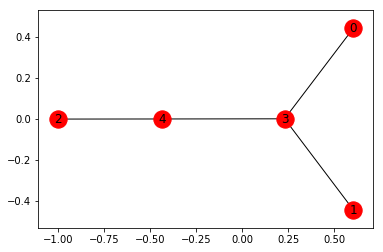

{(0, 1): 2.0, (0, 2): 3.0, (0, 3): 1.0, (0, 4): 2.0, (1, 2): 3.0, (1, 3): 1.0, (1, 4): 2.0, (2, 3): 2.0, (2, 4): 1.0, (3, 4): 1.0}


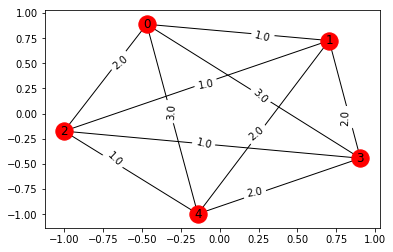

In [8]:
dataset, y = loadDataset("../../datasets/acyclic/dataset_bps.ds")
G1 = dataset[12]

nx.draw_networkx(G1)
# print(list(dataset[12][4]))

l = nx.shortest_path(G1)

l2 = nx.floyd_warshall_numpy(G1)
print(np.array(l2[0]))
print(l)
print(l2)
from matplotlib import pyplot as plt
plt.show()

S = getSPGraph(G1)
nx.draw_networkx(S)
pos = nx.spring_layout(S)
edge_labels = nx.get_edge_attributes(S,'cost')
print(edge_labels)
nx.draw_networkx_edge_labels(S, pos, edge_labels = edge_labels)
plt.show()

In [16]:
dataset, y = loadDataset("../../datasets/acyclic/dataset_bps.ds")
G1 = dataset[12]
G2 = dataset[20]
Kmatrix = spkernel(dataset)

print(Kmatrix)

--- 8.196406841278076 seconds ---
[[ 3.  1.  3. ...  1.  1.  1.]
 [ 1.  6.  1. ...  0.  0.  3.]
 [ 3.  1.  3. ...  1.  1.  1.]
 ...
 [ 1.  0.  1. ... 55. 21.  7.]
 [ 1.  0.  1. ... 21. 55.  7.]
 [ 1.  3.  1. ...  7.  7. 55.]]
